# Diabetic Retinopathy Detection

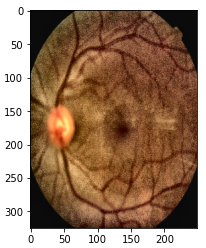 ; 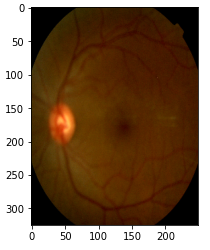

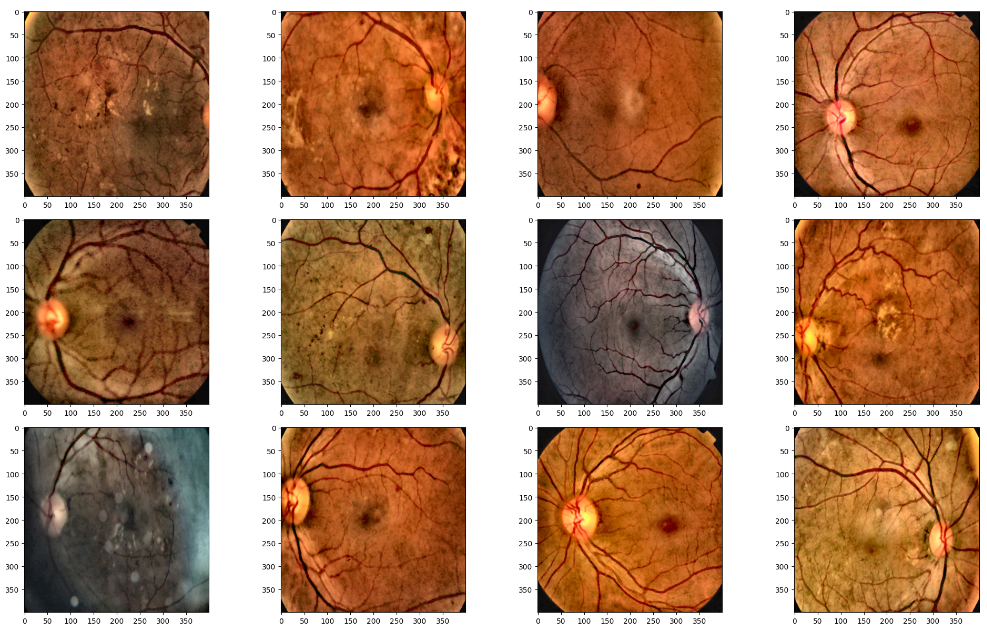

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from efficientnet.keras import EfficientNetB5
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [2]:
dataFrame = pd.read_csv('train.csv')

In [3]:
dataFrame.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

<AxesSubplot:>

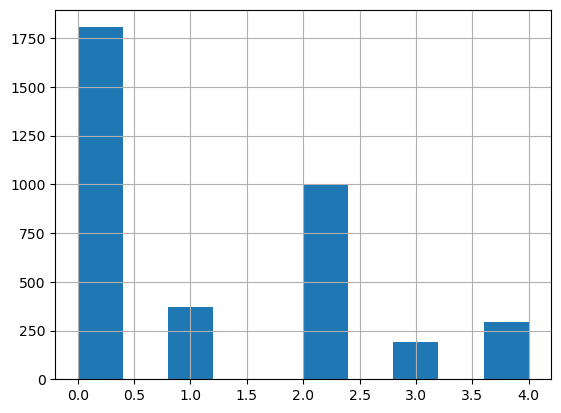

In [4]:
dataFrame['diagnosis'].hist()

In [5]:
dataFrame['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [6]:
files = os.listdir('train_images')

In [7]:
files

['000c1434d8d7.png',
 '001639a390f0.png',
 '0024cdab0c1e.png',
 '002c21358ce6.png',
 '005b95c28852.png',
 '0083ee8054ee.png',
 '0097f532ac9f.png',
 '00a8624548a9.png',
 '00b74780d31d.png',
 '00cb6555d108.png',
 '00cc2b75cddd.png',
 '00e4ddff966a.png',
 '00f6c1be5a33.png',
 '0104b032c141.png',
 '0124dffecf29.png',
 '0125fbd2e791.png',
 '012a242ac6ff.png',
 '014508ccb9cb.png',
 '0151781fe50b.png',
 '0161338f53cc.png',
 '0180bfa26c0b.png',
 '0182152c50de.png',
 '01b3aed3ed4c.png',
 '01c7808d901d.png',
 '01d9477b1171.png',
 '01eb826f6467.png',
 '01f7bb8be950.png',
 '0212dd31f623.png',
 '022f820027b8.png',
 '0231642cf1c2.png',
 '0232dfea7547.png',
 '02358b47ea89.png',
 '0243404e8a00.png',
 '025a169a0bb0.png',
 '02685f13cefd.png',
 '026dcd9af143.png',
 '02cd34a85b24.png',
 '02da652c74b8.png',
 '02dda30d3acf.png',
 '0304bedad8fe.png',
 '0318598cfd16.png',
 '032d7b0b4bf6.png',
 '033f2b43de6d.png',
 '034cb07a550f.png',
 '03676c71ed1b.png',
 '0369f3efe69b.png',
 '03747397839f.png',
 '03a7f4a5786

In [8]:
len(files)

3662

In [9]:
imageList = []

for i in files:
    imageRet = cv2.imread('train_images\\' + i)
    imageRet = cv2.resize(imageRet, (400, 400))
    imageRet = cv2.cvtColor(imageRet, cv2.COLOR_BGR2RGB)
    
    copyImageRet = imageRet.copy()
    copyImageRet = cv2.cvtColor(copyImageRet, cv2.COLOR_RGB2GRAY)
    
    blur = cv2.GaussianBlur(copyImageRet, (5, 5), 0)
    
    thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]
    
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0][0]
    contour = contour[:, 0, :]
    
    x1 = tuple(contour[contour[:, 0].argmin()])[0]
    y1 = tuple(contour[contour[:, 1].argmin()])[1]
    x2 = tuple(contour[contour[:, 0].argmax()])[0]
    y2 = tuple(contour[contour[:, 1].argmax()])[1]
    x = int(x2 - x1) * 4 // 50
    y = int(y2 - y1) * 5 // 50
    
    copy2ImageRet = imageRet.copy()
    #Acaba kırpıldı mı?
    if x2-x1 > 100 and y2 -y1 > 100: 
        copy2ImageRet = copy2ImageRet[y1 + y : y2 - y, x1 + x : x2 -x]
        copy2ImageRet = cv2.resize(copy2ImageRet, (400, 400))
    
    lab = cv2.cvtColor(copy2ImageRet, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit = 5.0, tileGridSize = ((8 ,8)))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl, a, b))
    
    last_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    medBluLast = cv2.medianBlur(last_image, 3)
    backgroundImage = cv2.medianBlur(last_image, 37)
    
    maskImage = cv2.addWeighted(medBluLast, 1, backgroundImage, -1, 255)
    
    imageDRData = cv2.bitwise_and(maskImage, medBluLast)
    
    imageList.append(imageDRData)

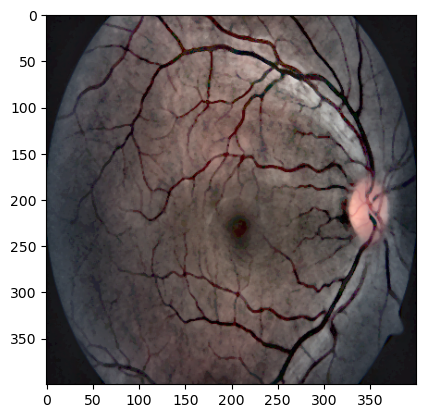

In [10]:
plt.imshow(imageList[6])

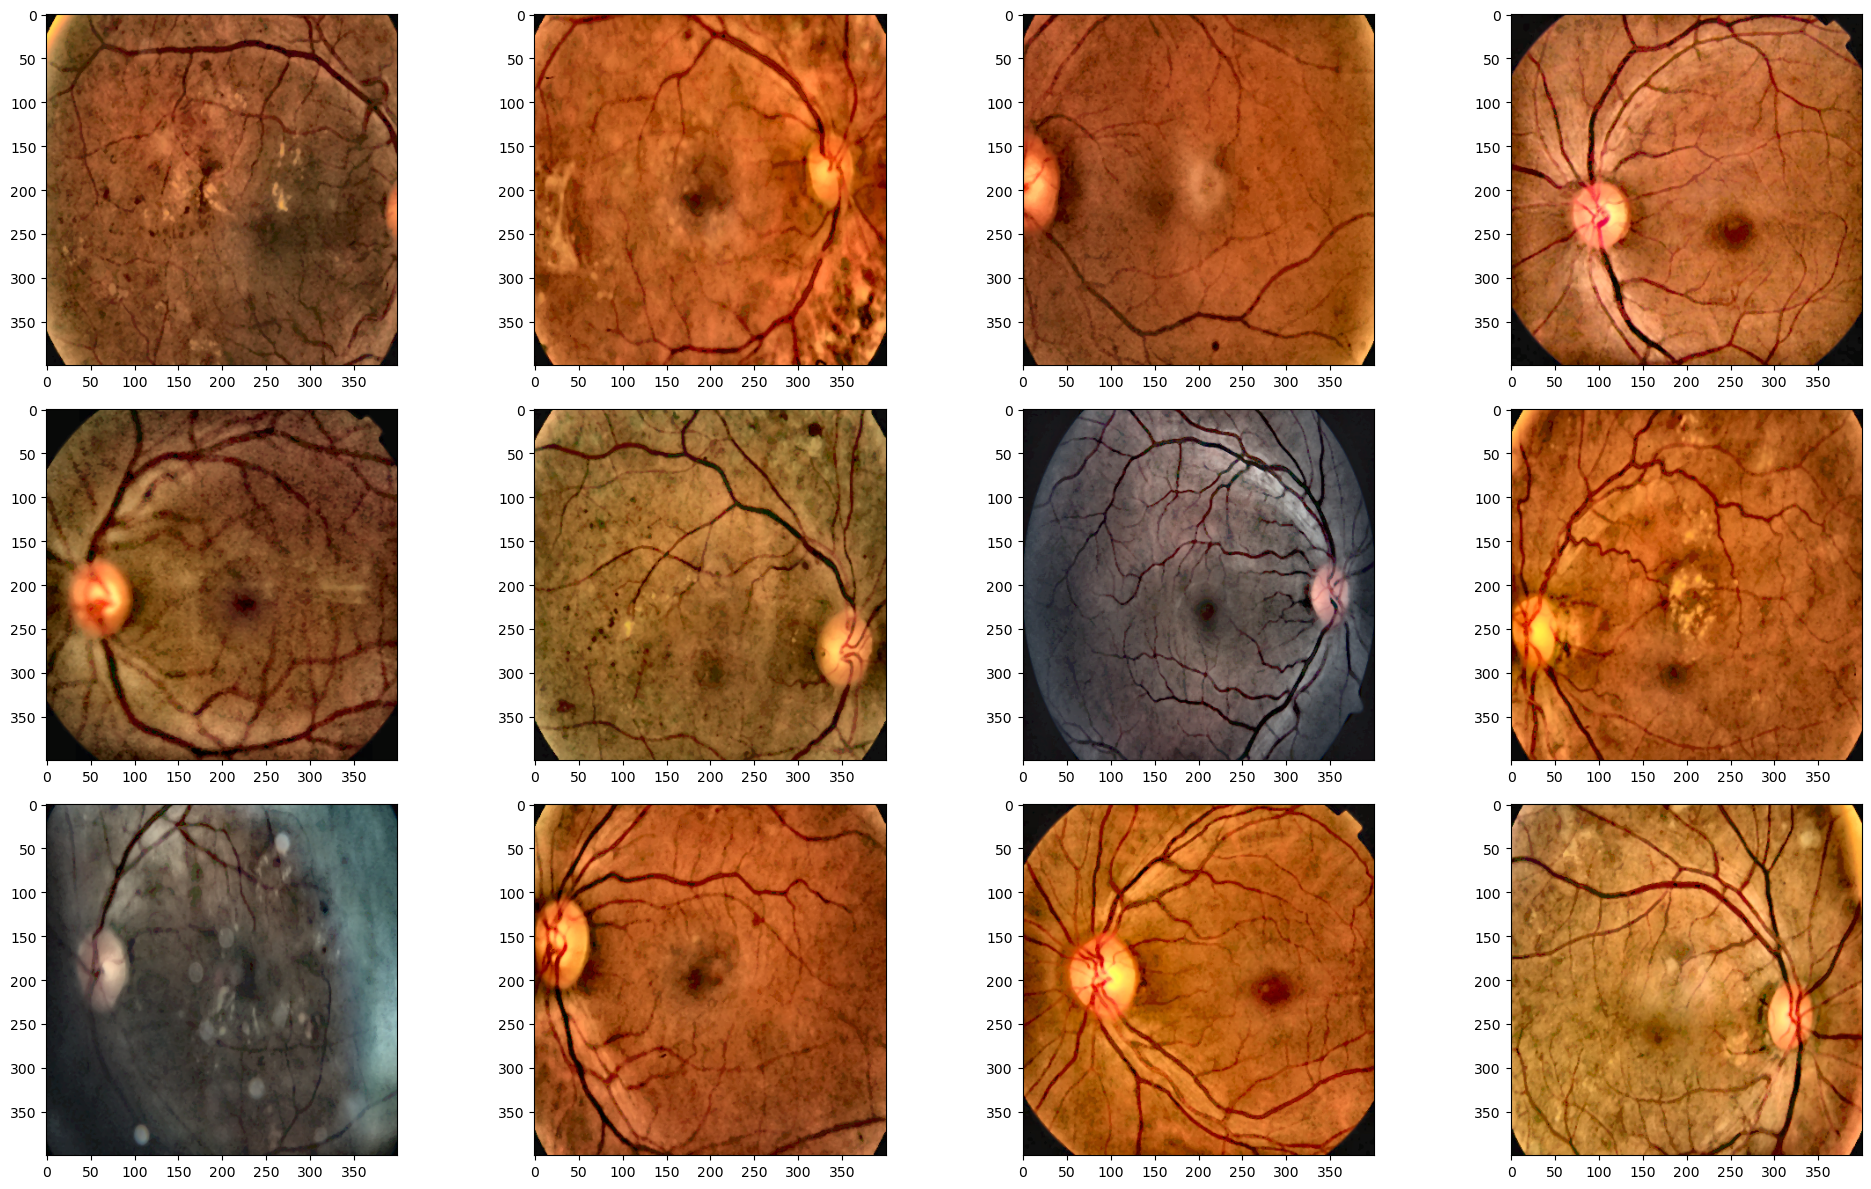

In [11]:
fig = plt.figure(figsize = (20, 12))

for i in range(12):
    showImage = imageList[i]
    fig.add_subplot(3, 4, i+1)
    plt.imshow(showImage)

plt.tight_layout()

In [12]:
dataFrame['diagnosis']

0       2
1       4
2       1
3       0
4       0
       ..
3657    2
3658    0
3659    2
3660    0
3661    2
Name: diagnosis, Length: 3662, dtype: int64

In [13]:
y_train = pd.get_dummies(dataFrame['diagnosis']).values #one hot encoded

In [14]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [15]:
dataFrame['diagnosis'][0]

2

In [16]:
y_train[0]

array([0, 0, 1, 0, 0], dtype=uint8)

In [17]:
last_y_train = np.ones(y_train.shape, dtype = 'uint8')

In [18]:
last_y_train

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [19]:
last_y_train[:, 4] = y_train[:, 4]

In [20]:
last_y_train

array([[1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       ...,
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0]], dtype=uint8)

In [21]:
for i in range(3, -1, -1):
    last_y_train[:, i] = np.logical_or(y_train[: ,i], last_y_train[:, i+1])

In [22]:
last_y_train

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [23]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [24]:
x_train = np.array(imageList)

In [25]:
x_train.shape

(3662, 400, 400, 3)

In [26]:
last_y_train.shape

(3662, 5)

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x_train, last_y_train, test_size = 0.15, random_state = 2019, shuffle = True)

In [28]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((3112, 400, 400, 3), (550, 400, 400, 3), (3112, 5), (550, 5))

In [29]:
datagen = ImageDataGenerator(horizontal_flip = True, vertical_flip = True)
data_generator = datagen.flow(x_train, y_train, batch_size = 2, seed = 2020)

In [30]:
odel = EfficientNetB5

In [31]:
odel()


In [32]:
model = Sequential()
model.add(EfficientNetB5(weights = 'imagenet', include_top=False, input_shape=(400, 400, 3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation = 'sigmoid'))

In [33]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00005), metrics =['accuracy']) #lr = learning rate

In [34]:
lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto', factor = 0.25, win_lr = 0.000001)

In [35]:
history = model.fit(data_generator, steps_per_epoch = 30, epochs = 5, validation_data = (x_val, y_val), callbacks =[lr])

Epoch 1/5
30/30 [==============================] - 337s 11s/step - loss: 0.6568 - accuracy: 0.5333 - val_loss: 0.6135 - val_accuracy: 0.9473 - lr: 5.0000e-05
Epoch 2/5
30/30 [==============================] - 303s 10s/step - loss: 0.5645 - accuracy: 0.9500 - val_loss: 0.5839 - val_accuracy: 0.9527 - lr: 5.0000e-05
Epoch 3/5
30/30 [==============================] - 293s 10s/step - loss: 0.4840 - accuracy: 0.9833 - val_loss: 0.5061 - val_accuracy: 1.0000 - lr: 5.0000e-05
Epoch 4/5
30/30 [==============================] - 313s 11s/step - loss: 0.4641 - accuracy: 1.0000 - val_loss: 0.4298 - val_accuracy: 1.0000 - lr: 5.0000e-05
Epoch 5/5
30/30 [==============================] - 316s 11s/step - loss: 0.3883 - accuracy: 1.0000 - val_loss: 0.3724 - val_accuracy: 1.0000 - lr: 5.0000e-05
